# Training a neural network with McSnow accretion output

This script applies a DNN to the regression problem compare with Seifert and Beheng (2001)

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


### Load data from netcdf

In [2]:
import numpy as np
import xarray as xr

In [3]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'
#fname1=mdir+edir+'autocon_train.nc'
#fname2=mdir+edir+'autocon_test.nc'
fname1=mdir+edir+'autocon_train_small.nc'
fname2=mdir+edir+'autocon_test_small.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 5, ii: 5, j: 5, jj: 5, k: 3, kk: 3, n: 2, nn: 2, nt: 4000)
Coordinates:
  * n           (n) int32 0 1
  * i           (i) int32 400 600 800 1000 2000
  * j           (j) int32 11 12 13 14 15
  * k           (k) int32 0 1 2
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n, i, j, k, nt) floa

# Prepare data for training

In [4]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    tau  = xr.open_dataset(fname).tau.values
    acc  = xr.open_dataset(fname).accr_mass.values
    Lc   = xr.open_dataset(fname).Lc.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nc   = xr.open_dataset(fname).Nc.values
    Nr   = xr.open_dataset(fname).Nr.values
    nu   = xr.open_dataset(fname).nu.values
    # transform everything except nu in log space
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    acc_min = 7e-10
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Xr = np.log(Lr/Nr, where=Nr>N_min)  # do Xr first!
    Nc = np.log(Nc, where=Nc>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    Nr = np.log(Nr, where=Nr>N_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    acc = np.log(acc, where=acc>acc_min, out=np.nan*acc)
    # put everything in a pandas dataframe    
    dataset = pd.DataFrame(np.array( [ acc.ravel(), Lc.ravel(), Lr.ravel(), Nc.ravel(), Nr.ravel(), nu.ravel(), tau.ravel() ]))
    dataset = dataset.T
    dataset.columns = ['acc','Lc','Lr','Nc','Nr','nu','tau'] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [5]:
dataset_train = read_and_prepare_data(fname1)
dataset_test  = read_and_prepare_data(fname2)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

### Inspect the data

In [6]:
dataset_train.describe()

acc            Lc            Lr            Nc            Nr  \
count  26785.000000  26785.000000  26785.000000  26785.000000  26785.000000   
mean     -16.996998     -9.679967     -8.820586     16.037180      8.442100   
std        2.108073      2.355078      2.134896      2.057231      2.179017   
min      -21.078321    -14.616381    -15.905665     10.979483      3.179074   
25%      -18.736071    -11.817841     -9.862300     14.274485      6.772529   
50%      -16.888884     -8.972419     -7.854557     16.553825      8.678412   
75%      -15.359086     -7.655263     -7.423600     17.772684     10.234542   
max      -12.010792     -6.216094     -6.217121     19.665518     13.366846   

                 nu           tau  
count  26785.000000  26785.000000  
mean       1.041142     -1.483247  
std        0.812279      2.111375  
min        0.000000     -9.689633  
25%        0.000000     -2.493961  
50%        1.000000     -0.225659  
75%        2.000000     -0.011461  
max        2.000000     -0.001001

In [7]:
dataset_test.describe()

acc            Lc            Lr            Nc            Nr  \
count  10278.000000  10278.000000  10278.000000  10278.000000  10278.000000   
mean     -16.859783     -9.616609     -8.738249     16.111717      8.487582   
std        2.097708      2.379864      2.156258      2.066061      2.196175   
min      -21.078836    -14.502958    -15.778172     11.106323      3.334302   
25%      -18.590024    -11.788280     -9.768718     14.320136      6.793202   
50%      -16.741873     -8.888388     -7.646198     16.641495      8.755343   
75%      -15.081455     -7.603827     -7.275571     17.911129     10.292547   
max      -12.579626     -6.503845     -6.504746     19.373465     12.950388   

                nu           tau  
count  10278.00000  10278.000000  
mean       1.04135     -1.501374  
std        0.81150      2.147022  
min        0.00000     -9.274020  
25%        0.00000     -2.523775  
50%        1.00000     -0.217713  
75%        2.00000     -0.010582  
max        2.00000     -0.001002

### Reduce the data

In [8]:
def reduce_data(dataset):
    idx = dataset[ dataset['tau'] > np.log(0.95) ].index
    dataset.drop(idx,inplace=True)
    return dataset

In [9]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)

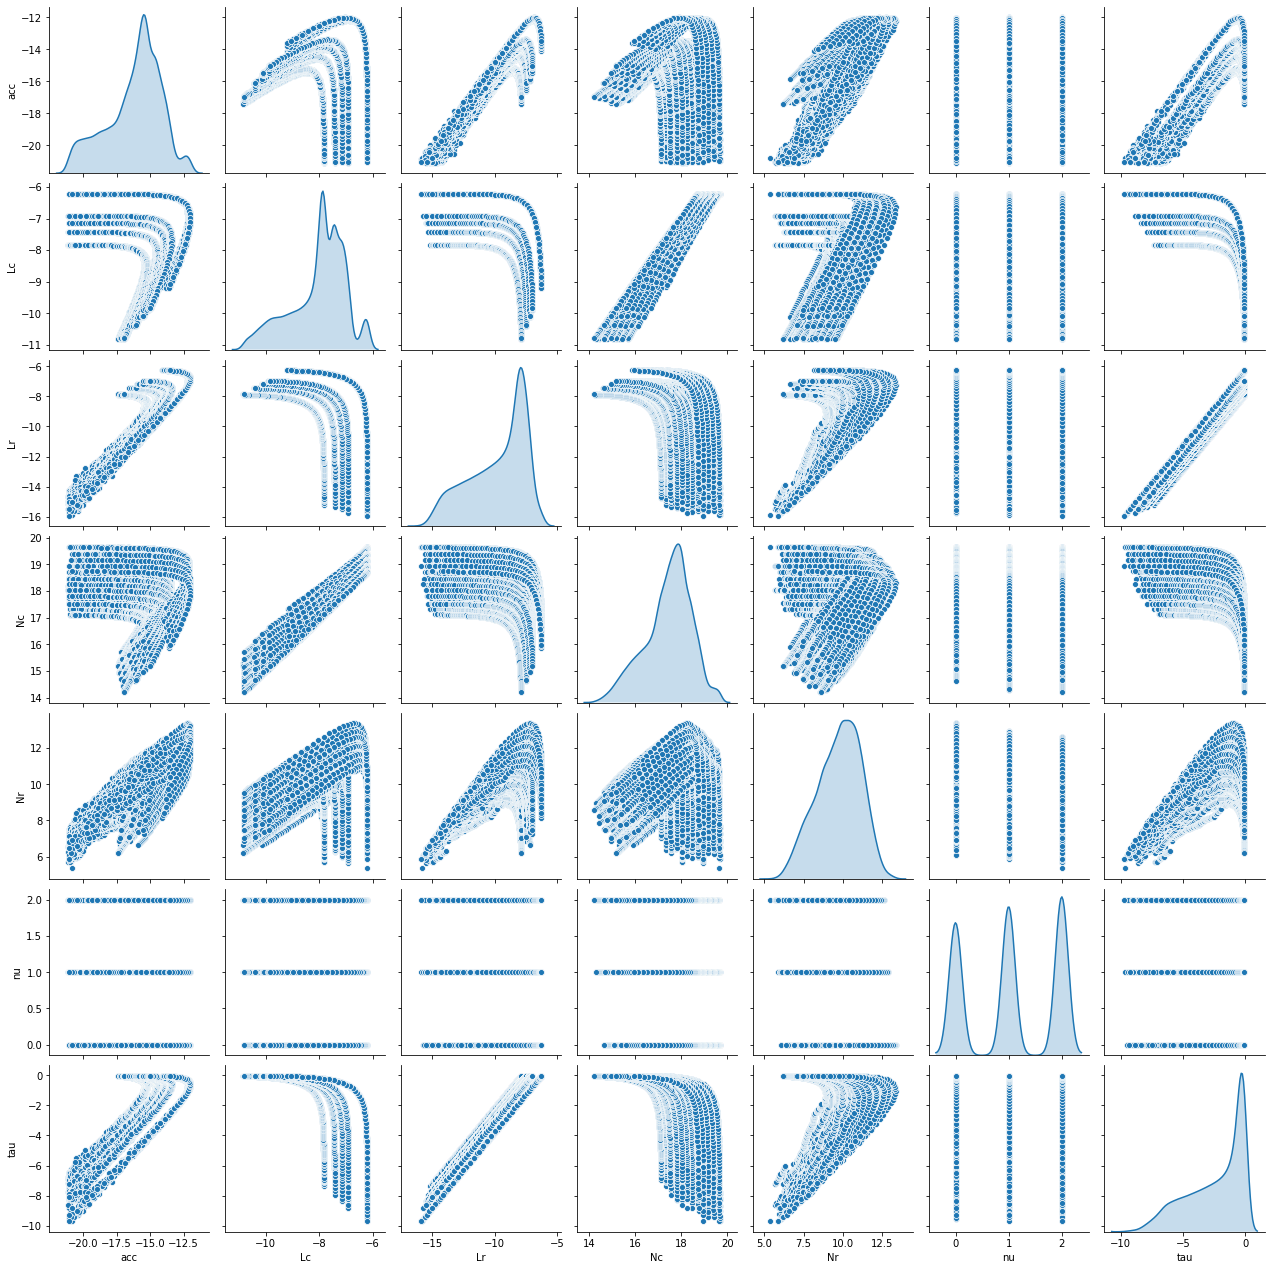

In [10]:
sns.pairplot(dataset_train[['acc','Lc','Lr','Nc','Nr','nu','tau']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [11]:
train_dataset0 = dataset_train.copy()
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()

test_dataset0 = dataset_test.copy()
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()

In [12]:
train_dataset0 = train_dataset0.drop(['Nc','Nr','nu','tau'], axis=1)
train_dataset1 = train_dataset1.drop(['Nr','nu','tau'], axis=1)
train_dataset2 = train_dataset2.drop(['nu','tau'], axis=1)
train_dataset3 = train_dataset3.drop("tau", axis=1)
train_dataset4 = train_dataset4.drop(['Nc','Nr','nu'], axis=1)

In [13]:
test_dataset0 = test_dataset0.drop(['Nc','Nr','nu','tau'], axis=1)
test_dataset1 = test_dataset1.drop(['Nr','nu','tau'], axis=1)
test_dataset2 = test_dataset2.drop(['nu','tau'], axis=1)
test_dataset3 = test_dataset3.drop('tau', axis=1)
test_dataset4 = test_dataset4.drop(['Nc','Nr','nu'], axis=1)

In [14]:
train_stats0 = train_dataset0.describe()
train_stats0.pop("acc")
train_stats0 = train_stats0.transpose()
train_stats0

count      mean       std        min        25%       50%       75%  \
Lc  16523.0 -8.027051  1.013095 -10.821355  -8.583910 -7.838439 -7.364206   
Lr  16523.0 -9.734813  2.252793 -15.905665 -11.399084 -9.080849 -7.909213   

         max  
Lc -6.216094  
Lr -6.267761

In [15]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("acc")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Lc  16523.0  -8.027051  1.013095 -10.821355  -8.583910  -7.838439  -7.364206   
Lr  16523.0  -9.734813  2.252793 -15.905665 -11.399084  -9.080849  -7.909213   
Nc  16523.0  17.433821  1.003736  14.212520  16.856462  17.568079  18.125973   

          max  
Lc  -6.216094  
Lr  -6.267761  
Nc  19.665518

In [16]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("acc")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%        75%  \
Lc  16523.0  -8.027051  1.013095 -10.821355  -8.583910  -7.838439  -7.364206   
Lr  16523.0  -9.734813  2.252793 -15.905665 -11.399084  -9.080849  -7.909213   
Nc  16523.0  17.433821  1.003736  14.212520  16.856462  17.568079  18.125973   
Nr  16523.0   9.750391  1.385431   5.359798   8.791457   9.886423  10.798204   

          max  
Lc  -6.216094  
Lr  -6.267761  
Nc  19.665518  
Nr  13.366846

In [17]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("acc")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%        75%  \
Lc  16523.0  -8.027051  1.013095 -10.821355  -8.583910  -7.838439  -7.364206   
Lr  16523.0  -9.734813  2.252793 -15.905665 -11.399084  -9.080849  -7.909213   
Nc  16523.0  17.433821  1.003736  14.212520  16.856462  17.568079  18.125973   
Nr  16523.0   9.750391  1.385431   5.359798   8.791457   9.886423  10.798204   
nu  16523.0   1.058767  0.811200   0.000000   0.000000   1.000000   2.000000   

          max  
Lc  -6.216094  
Lr  -6.267761  
Nc  19.665518  
Nr  13.366846  
nu   2.000000

In [18]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("acc")
train_stats4 = train_stats4.transpose()
train_stats4

count      mean       std        min        25%       50%       75%  \
Lc   16523.0 -8.027051  1.013095 -10.821355  -8.583910 -7.838439 -7.364206   
Lr   16523.0 -9.734813  2.252793 -15.905665 -11.399084 -9.080849 -7.909213   
tau  16523.0 -2.397087  2.246509  -9.689633  -4.031431 -1.702539 -0.361760   

          max  
Lc  -6.216094  
Lr  -6.267761  
tau -0.051293

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [19]:
train_labels0 = train_dataset0.pop('acc')
train_labels1 = train_dataset1.pop('acc')
train_labels2 = train_dataset2.pop('acc')
train_labels3 = train_dataset3.pop('acc')
train_labels4 = train_dataset4.pop('acc')

test_labels0  = test_dataset0.pop('acc')
test_labels1  = test_dataset1.pop('acc')
test_labels2  = test_dataset2.pop('acc')
test_labels3  = test_dataset3.pop('acc')
test_labels4  = test_dataset4.pop('acc')

### Normalize the data

In [20]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data0 = norm(train_dataset0,train_stats0)
normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)

normed_test_data0 = norm(test_dataset0,train_stats0)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)

In [21]:
normed_train_stats0 = normed_train_data0.describe()
normed_train_stats0 = normed_train_stats0.transpose()
normed_train_stats0

count      mean       std       min       25%       50%       75%  \
Lc  16523.0 -0.000018  1.000001 -2.758186 -0.549662  0.186174  0.654277   
Lr  16523.0 -0.000002  1.000000 -2.739201 -0.738759  0.290290  0.810371   

         max  
Lc  1.787549  
Lr  1.539001

In [22]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count      mean       std       min       25%       50%       75%  \
Lc  16523.0 -0.000018  1.000001 -2.758186 -0.549662  0.186174  0.654277   
Lr  16523.0 -0.000002  1.000000 -2.739201 -0.738759  0.290290  0.810371   
Nc  16523.0 -0.000024  0.999999 -3.209310 -0.575209  0.133758  0.689575   

         max  
Lc  1.787549  
Lr  1.539001  
Nc  2.223389

In [23]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count      mean       std       min       25%       50%       75%  \
Lc  16523.0 -0.000018  1.000001 -2.758186 -0.549662  0.186174  0.654277   
Lr  16523.0 -0.000002  1.000000 -2.739201 -0.738759  0.290290  0.810371   
Nc  16523.0 -0.000024  0.999999 -3.209310 -0.575209  0.133758  0.689575   
Nr  16523.0  0.000010  1.000000 -3.169116 -0.692155  0.098188  0.756308   

         max  
Lc  1.787549  
Lr  1.539001  
Nc  2.223389  
Nr  2.610346

In [24]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean       std       min       25%       50%       75%  \
Lc  16523.0 -1.802370e-05  1.000001 -2.758186 -0.549662  0.186174  0.654277   
Lr  16523.0 -2.466934e-06  1.000000 -2.739201 -0.738759  0.290290  0.810371   
Nc  16523.0 -2.351182e-05  0.999999 -3.209310 -0.575209  0.133758  0.689575   
Nr  16523.0  1.011744e-05  1.000000 -3.169116 -0.692155  0.098188  0.756308   
nu  16523.0 -4.395375e-08  0.999986 -1.305185 -1.305185 -0.072444  1.160297   

         max  
Lc  1.787549  
Lr  1.539001  
Nc  2.223389  
Nr  2.610346  
nu  1.160297

In [25]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count      mean       std       min       25%       50%       75%  \
Lc   16523.0 -0.000018  1.000001 -2.758186 -0.549662  0.186174  0.654277   
Lr   16523.0 -0.000002  1.000000 -2.739201 -0.738759  0.290290  0.810371   
tau  16523.0  0.000002  1.000000 -3.246168 -0.727504  0.309167  0.905995   

          max  
Lc   1.787549  
Lr   1.539001  
tau  1.044195

# The model

## Build the model

In [26]:
def build_model(ncol):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [27]:
model = build_model(2)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [29]:
example_batch  = normed_train_data0[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.48883027],
       [-0.48324654],
       [-0.47764328],
       [-0.4742906 ],
       [-0.4704136 ],
       [-0.46682468],
       [-0.46239048],
       [-0.45671257],
       [-0.45220968],
       [-0.44692582]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [30]:
# maximum number, but we use early stopping
EPOCHS = 1000

# part of training data that is used for validation during training
VALSPLIT = 0.2

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# for collecting the histories
histories = {}

In [31]:
model0 = build_model(len(normed_train_data0.keys()))

early_history0 = model0.fit(normed_train_data0, train_labels0, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:122.7914,  mae:10.3278,  mse:122.7913,  val_loss:17.0852,  val_mae:3.6014,  val_mse:17.0852,  
.............................

Text(0, 0.5, 'MAE')

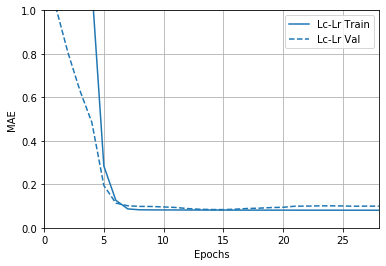

In [32]:
histories['Lc-Lr'] = early_history0

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [33]:
model1 = build_model(len(normed_train_data1.keys()))

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:141.3949,  mae:11.2724,  mse:141.3949,  val_loss:27.3265,  val_mae:4.8021,  val_mse:27.3265,  
........................................

Text(0, 0.5, 'MAE')

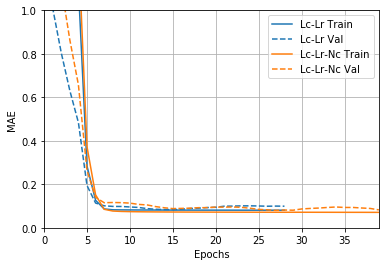

In [34]:
histories['Lc-Lr-Nc'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [35]:
model2 = build_model(len(normed_train_data2.keys()))

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:147.3345,  mae:11.5506,  mse:147.3345,  val_loss:29.9979,  val_mae:5.0761,  val_mse:29.9979,  
.......................

Text(0, 0.5, 'MAE')

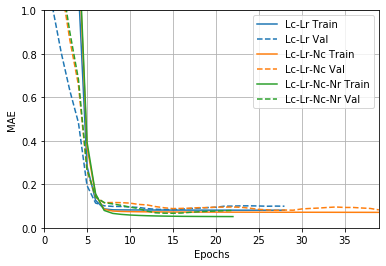

In [36]:
histories['Lc-Lr-Nc-Nr'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [37]:
model3 = build_model(len(normed_train_data3.keys()))

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:141.3677,  mae:11.2532,  mse:141.3677,  val_loss:24.4645,  val_mae:4.5228,  val_mse:24.4645,  
...............................................

Text(0, 0.5, 'MAE')

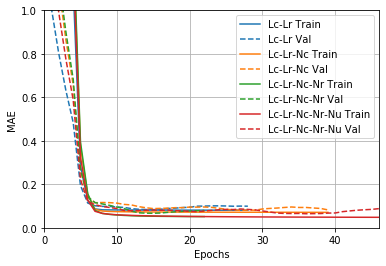

In [38]:
histories['Lc-Lr-Nc-Nr-nu'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [39]:
model4 = build_model(len(normed_train_data4.keys()))

early_history4 = model4.fit(normed_train_data4, train_labels4, 
                    epochs=EPOCHS, validation_split=VALSPLIT, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:128.8947,  mae:10.6262,  mse:128.8946,  val_loss:21.2447,  val_mae:4.1151,  val_mse:21.2447,  
........................

Text(0, 0.5, 'MAE of AU')

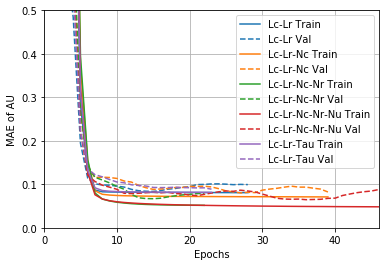

In [40]:
histories['Lc-Lr-tau'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.5])
plt.ylabel('MAE of AU')

Text(0, 0.5, 'MSE of AU')

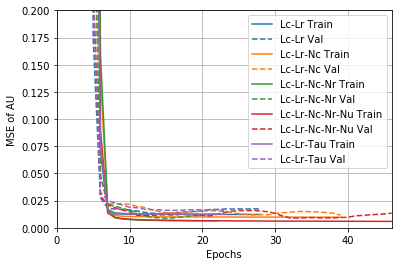

In [41]:
plotter.plot(histories, metric = "mse")
plt.ylim([0, 0.2])
plt.ylabel('MSE of AU')

In [42]:
loss0, mae0, mse0 = model0.evaluate(normed_test_data0, test_labels0, verbose=2)

print("Testing set for model 0, Mean Abs Error: {:10.5f}".format(mae0))

6292/6292 - 0s - loss: 0.0180 - mae: 0.1038 - mse: 0.0180
Testing set for model 0, Mean Abs Error:    0.10377


In [43]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

6292/6292 - 0s - loss: 0.0086 - mae: 0.0697 - mse: 0.0086
Testing set for model 1, Mean Abs Error:    0.06965


In [44]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:10.5f}".format(mae2))

6292/6292 - 0s - loss: 0.0150 - mae: 0.0769 - mse: 0.0150
Testing set for model 2, Mean Abs Error:    0.07693


In [45]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:10.5f}".format(mae3))

6292/6292 - 0s - loss: 0.0077 - mae: 0.0711 - mse: 0.0077
Testing set for model 3, Mean Abs Error:    0.07110


In [46]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data4, test_labels4, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:10.5f}".format(mae4))

6292/6292 - 0s - loss: 0.0132 - mae: 0.0836 - mse: 0.0132
Testing set for model 4, Mean Abs Error:    0.08356


# Make predictions

Finally, predict the fall velocity values using data in the testing set:

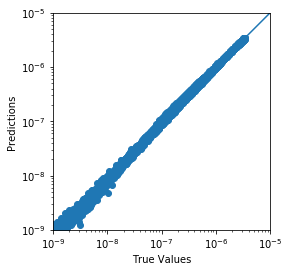

In [47]:
test_acc0 = np.exp(test_labels0)
test_acc1 = np.exp(test_labels1)
test_acc2 = np.exp(test_labels2)
test_acc3 = np.exp(test_labels3)
test_acc4 = np.exp(test_labels4)

test_predict0 = np.exp(model0.predict(normed_test_data0).flatten())
test_predict1 = np.exp(model1.predict(normed_test_data1).flatten())


test_predict2 = np.exp(model2.predict(normed_test_data2).flatten())

amin, amax = 1e-9, 1e-5

a = plt.axes(aspect='equal')
plt.scatter(test_acc2, test_predict2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

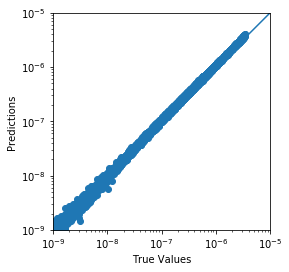

In [48]:
test_predict3 = np.exp(model3.predict(normed_test_data3).flatten())

a = plt.axes(aspect='equal')
plt.scatter(test_acc3, test_predict3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

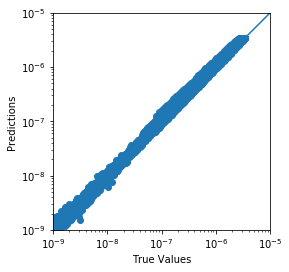

In [49]:
test_predict4 = np.exp(model4.predict(normed_test_data4).flatten())

a = plt.axes(aspect='equal')
plt.scatter(test_acc4, test_predict4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [50]:
test_dataset4.describe()

Lc           Lr          tau
count  6292.000000  6292.000000  6292.000000
mean     -7.916197    -9.677704    -2.445220
std       0.966241     2.288284     2.287552
min     -10.598797   -15.778172    -9.274020
25%      -8.444451   -11.364486    -4.113916
50%      -7.627963    -8.999610    -1.735783
75%      -7.270972    -7.730621    -0.367840
max      -6.503845    -6.555487    -0.051351

In [51]:
qc  = np.exp(np.array(test_dataset4.Lc))
qr  = np.exp(np.array(test_dataset4.Lr))

tau2 = qr/(qc+qr)

## SB2001 autoconversion rate, original and re-trained on current data

In [52]:
kcr = 5.78      # Long kernel in m3 kg-1 s-1 

phi = (tau2 / (tau2 + 5e-4))**4

accSB = kcr * qc * qr * phi


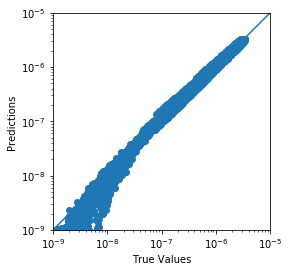

In [53]:
test_predict_sb = accSB

a = plt.axes(aspect='equal')
plt.scatter(test_acc4, test_predict_sb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Power law regression 

from notebook 'McSnow_autocon_powerlaws'

In [54]:
fac = 6.0
a = 1.1
b = 1.0
c = 0.1


# AU = fac * Lc**a * Nc**b * nu**c
acPwr = fac * np.power(qc,a) * np.power(qr,b) #* np.power(nu+1,c)  

In [55]:
np.mean(acPwr)

1.9276982e-07

## Final statistics 

In [56]:
acc0 = test_predict0
acc1 = test_predict1
acc2 = test_predict2
acc3 = test_predict3
acc4 = test_predict4

accTruth = test_acc4

In [57]:
np.max(accTruth)

3.441421085881302e-06

In [58]:
def mean_abs_error(au, auTrue):  
    return np.mean(np.abs(au - auTrue))

def mean_sqr_error(au, auTrue):    
    return np.sqrt(np.mean((au - auTrue)**2))                   

In [59]:
mae0 = mean_abs_error(acc0,test_acc0)
mae1 = mean_abs_error(acc1,test_acc1)
mae2 = mean_abs_error(acc2,test_acc2)
mae3 = mean_abs_error(acc3,test_acc3)
mae4 = mean_abs_error(acc4,test_acc4)
maeSB = mean_abs_error(accSB,accTruth)
#maeKK  = mean_abs_error(accKK,accTruth)
#maePwr = mean_abs_error(accPwr,accTruth)

mse0 = mean_sqr_error(acc0,test_acc0)
mse1 = mean_sqr_error(acc1,test_acc1)
mse2 = mean_sqr_error(acc2,test_acc2)
mse3 = mean_sqr_error(acc3,test_acc3)
mse4 = mean_sqr_error(acc4,test_acc4)
mseSB = mean_sqr_error(accSB,accTruth)
#mseSB2 = mean_sqr_error(accSB2,accTruth)
#mseKK  = mean_sqr_error(accKK,accTruth)
#msePwr = mean_sqr_error(accPwr,accTruth)

mae = [ mae0, mae1, mae2, mae3, mae4, maeSB ] #, maeSB2, maeKK, maePwr ]
mse = [ mse0, mse1, mse2, mse3, mse4, mseSB ] #, mseSB2, mseKK, msePwr ]

In [60]:
mae

[2.6708738332104076e-08,
 2.2402657506859214e-08,
 9.341182050093266e-09,
 3.221439115463909e-08,
 2.9831078052211524e-08,
 3.0600880052134016e-08]

In [61]:
labels = list(histories.keys())
labels.append('SB2001')
labels

['Lc-Lr', 'Lc-Lr-Nc', 'Lc-Lr-Nc-Nr', 'Lc-Lr-Nc-Nr-nu', 'Lc-Lr-tau', 'SB2001']

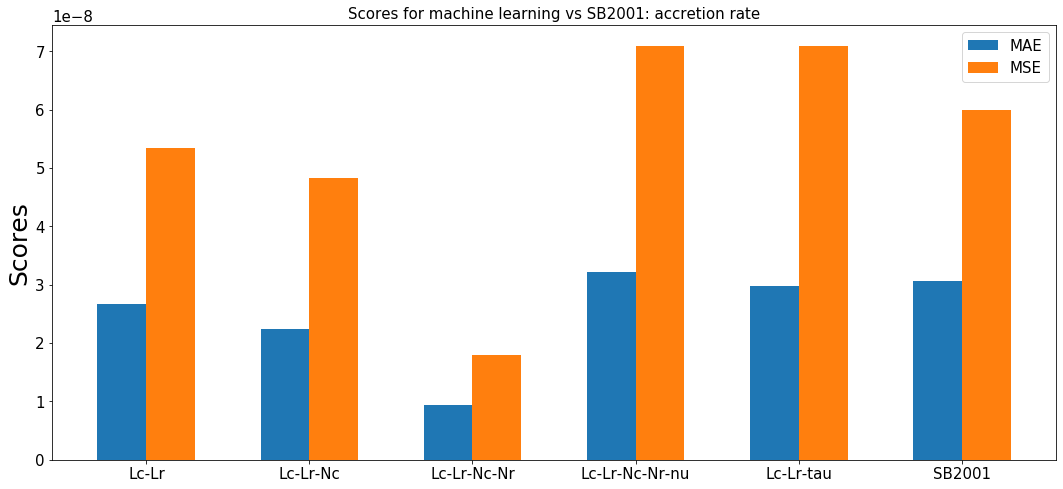

In [62]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size
#labels = [ 'Lc-Lr', 'Lc-Lr-Nc', 'Lc-Lr-Nr', 'Lc-Lr-Nc-Nr', 'Lc-Lr-Nc-Nr-nu', 'SB2001' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for machine learning vs SB2001: accretion rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#fig.tight_layout()

plt.show()



# Save models and normalization

In [63]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model0.save('saved_model/accretion_v3_LcLr_16x16') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/accretion_v3_LcLr_16x16/assets


In [64]:
model1.save('saved_model/accretion_v3_LcLrNc_16x16') 

INFO:tensorflow:Assets written to: saved_model/accretion_v3_LcLrNc_16x16/assets


In [65]:
model2.save('saved_model/accretion_v3_LcLrNcNr_16x16') 

INFO:tensorflow:Assets written to: saved_model/accretion_v3_LcLrNcNr_16x16/assets


In [66]:
model3.save('saved_model/accretion_v3_LcLrNcNrNu_16x16') 

INFO:tensorflow:Assets written to: saved_model/accretion_v3_LcLrNcNrNu_16x16/assets


In [67]:
# save train_stats for normalization of input data in Pandas pickle format
train_stats0.to_pickle('saved_model/accretion_LcLr_v3_16x16_norm.pickle')
train_stats1.to_pickle('saved_model/accretion_LcLrNc_v3_16x16_norm.pickle')
train_stats2.to_pickle('saved_model/accretion_LcLrNcNr_v3_16x16_norm.pickle')
train_stats3.to_pickle('saved_model/accretion_LcLrNcNrNu_v3_16x16_norm.pickle')

# Model on gridded data to visualize dependencies

In [68]:

qc1d = np.linspace(0.1,1.0,10) * 1e-3
qr1d = np.linspace(0.1,1.0,11)
nu1d = np.linspace(0,3,6)
rc1d = np.linspace(11,15,9) * 1e-6
rr1d = np.linspace(0.05,2,12) * 1e-3

qc3d, qr3d, rc3d, rr3d, nu3d = np.meshgrid(qc1d, qr1d, rc1d, rr1d, nu1d)

xc3d = 4./3. * 3.14 * 1e3 * rc3d**3
nc3d = qc3d/xc3d
xr3d = 4./3. * 3.14 * 1e3 * rr3d**3
nr3d = qr3d/xr3d

In [69]:
nr3d.shape

(11, 10, 9, 12, 6)

In [70]:
nc3d.shape

(11, 10, 9, 12, 6)

In [71]:
gdata = pd.DataFrame(np.array( [ np.log(qc3d.ravel()), np.log(qr3d.ravel()), np.log(nc3d.ravel()), np.log(nr3d.ravel()), nu3d.ravel() ]))
gdata = gdata.T
gdata.columns = [ 'Lc','Lr','Nc','Nr','nu' ] 

In [72]:
gdata.describe()

Lc            Lr            Nc            Nr            nu
count  71280.000000  71280.000000  71280.000000  71280.000000  71280.000000
mean      -7.699899     -0.787151     17.727048     12.528157      1.500000
std        0.695412      0.684916      0.757350      3.139693      1.024702
min       -9.210340     -2.302585     15.772381      8.001579      0.000000
25%       -8.111728     -1.272966     17.262637     10.334491      0.600000
50%       -7.509742     -0.597837     17.866022     11.600517      1.500000
75%       -7.130899     -0.198451     18.281944     13.813863      2.400000
max       -6.907755      0.000000     19.005430     21.370803      3.000000

In [73]:
gdata0 = gdata.copy()
gdata2 = gdata.copy()
gdata3 = gdata.copy()

In [74]:
gdata0 = gdata.drop(['Nc','Nr','nu'], axis=1)
gdata2 = gdata.drop(['nu'], axis=1)

#train_dataset0 = train_dataset0.drop(['Nc','Nr','nu','tau'], axis=1)
#train_dataset1 = train_dataset1.drop(['Nr','nu','tau'], axis=1)
#train_dataset2 = train_dataset2.drop(['nu','tau'], axis=1)
#train_dataset3 = train_dataset3.drop("tau", axis=1)
#train_dataset4 = train_dataset4.drop(['Nc','Nr','nu'], axis=1)

In [75]:
gdata3.head()

Lc        Lr         Nc         Nr   nu
0 -9.21034 -2.302585  16.702845  19.068217  0.0
1 -9.21034 -2.302585  16.702845  19.068217  0.6
2 -9.21034 -2.302585  16.702845  19.068217  1.2
3 -9.21034 -2.302585  16.702845  19.068217  1.8
4 -9.21034 -2.302585  16.702845  19.068217  2.4

In [76]:
gdata3_stats = gdata3.describe()
gdata3_stats.transpose()

count       mean       std        min        25%        50%        75%  \
Lc  71280.0  -7.699899  0.695412  -9.210340  -8.111728  -7.509742  -7.130899   
Lr  71280.0  -0.787151  0.684916  -2.302585  -1.272966  -0.597837  -0.198451   
Nc  71280.0  17.727048  0.757350  15.772381  17.262637  17.866022  18.281944   
Nr  71280.0  12.528157  3.139693   8.001579  10.334491  11.600517  13.813863   
nu  71280.0   1.500000  1.024702   0.000000   0.600000   1.500000   2.400000   

          max  
Lc  -6.907755  
Lr   0.000000  
Nc  19.005430  
Nr  21.370803  
nu   3.000000

In [77]:
normed_gdata0 = norm(gdata0,train_stats0)
normed_gdata2 = norm(gdata2,train_stats2)
normed_gdata3 = norm(gdata3,train_stats3)

normed_gdata3_stats = normed_gdata3.describe()
normed_gdata3_stats.transpose()

count      mean       std       min       25%       50%       75%  \
Lc  71280.0  0.322923  0.686424 -1.167995 -0.083583  0.510623  0.884569   
Lr  71280.0  3.971808  0.304030  3.299117  3.756158  4.055843  4.233128   
Nc  71280.0  0.292136  0.754531 -1.655255 -0.170546  0.430592  0.844966   
Nr  71280.0  2.004983  2.266221 -1.262287  0.421602  1.335415  2.933002   
nu  71280.0  0.543927  1.263193 -1.305185 -0.565541  0.543927  1.653394   

         max  
Lc  1.104828  
Lr  4.321219  
Nc  1.565759  
Nr  8.387577  
nu  2.393039

In [78]:
acc0 = model0.predict(normed_gdata0).flatten()
acc2 = model2.predict(normed_gdata2).flatten()
acc3 = model3.predict(normed_gdata3).flatten()

In [79]:
acc3d_model0 = np.exp(np.reshape(acc0,qc3d.shape))
acc3d_model2 = np.exp(np.reshape(acc2,qc3d.shape))
acc3d_model3 = np.exp(np.reshape(acc3,qc3d.shape))

In [80]:
qc3d.shape

(11, 10, 9, 12, 6)

In [81]:
kcr = 5.78      # Long kernel in m3 kg-1 s-1 

tau = qr3d/(qc3d+qr3d)
phi = (tau / (tau + 5e-4))**4

accSB = kcr * qc3d * qr3d * phi

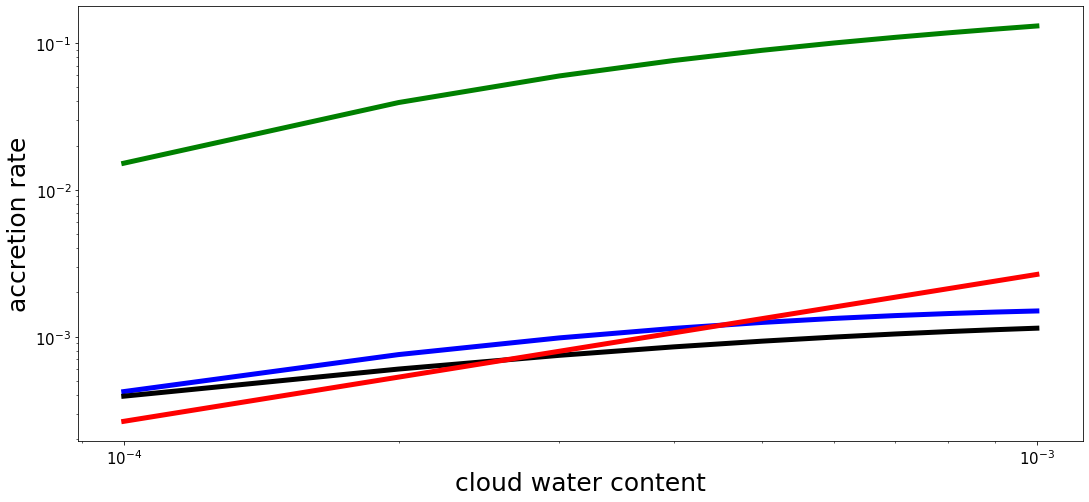

In [82]:
iqc = 5
iqr = 4
irc = 4
irr = 3
inu = 1

plt.plot(qc3d[iqr,:,irc,irr,inu], acc3d_model0[iqr,:,irc,irr,inu], 'g-', linewidth=5)
plt.plot(qc3d[iqr,:,irc,irr,inu], acc3d_model2[iqr,:,irc,irr,inu], 'b-', linewidth=5)
plt.plot(qc3d[iqr,:,irc,irr,inu], acc3d_model3[iqr,:,irc,irr,inu], 'k-', linewidth=5)
plt.plot(qc3d[iqr,:,irc,irr,inu], accSB[iqr,:,irc,irr,inu], 'r-', linewidth=5)

plt.xlabel('cloud water content')
plt.ylabel('accretion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()

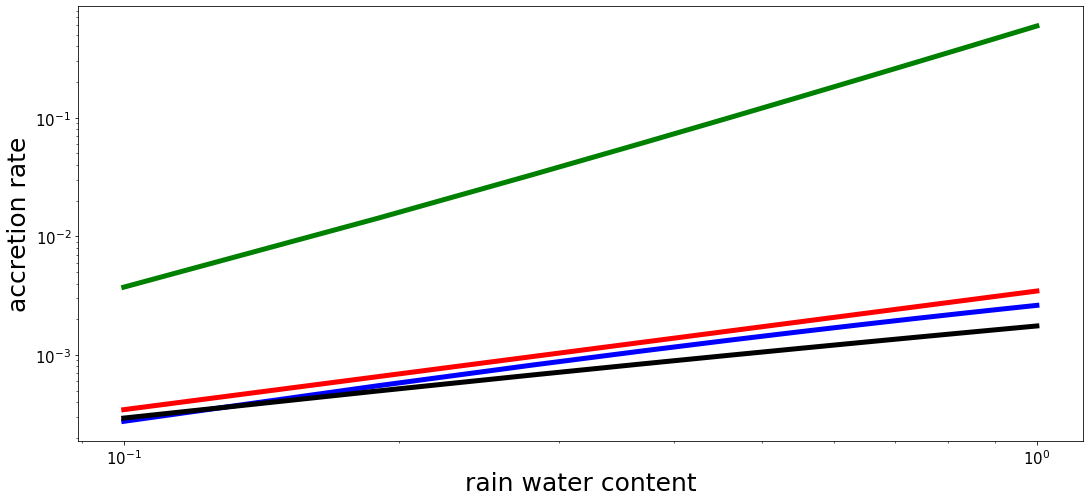

In [83]:
plt.plot(qr3d[:,iqc,irc,irr,inu], acc3d_model0[:,iqc,irc,irr,inu], 'g-', linewidth=5)
plt.plot(qr3d[:,iqc,irc,irr,inu], acc3d_model2[:,iqc,irc,irr,inu], 'b-', linewidth=5)
plt.plot(qr3d[:,iqc,irc,irr,inu], acc3d_model3[:,iqc,irc,irr,inu], 'k-', linewidth=5)
plt.plot(qr3d[:,iqc,irc,irr,inu], accSB[:,iqc,irc,irr,inu], 'r-', linewidth=5)

plt.xlabel('rain water content')
plt.ylabel('accretion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()

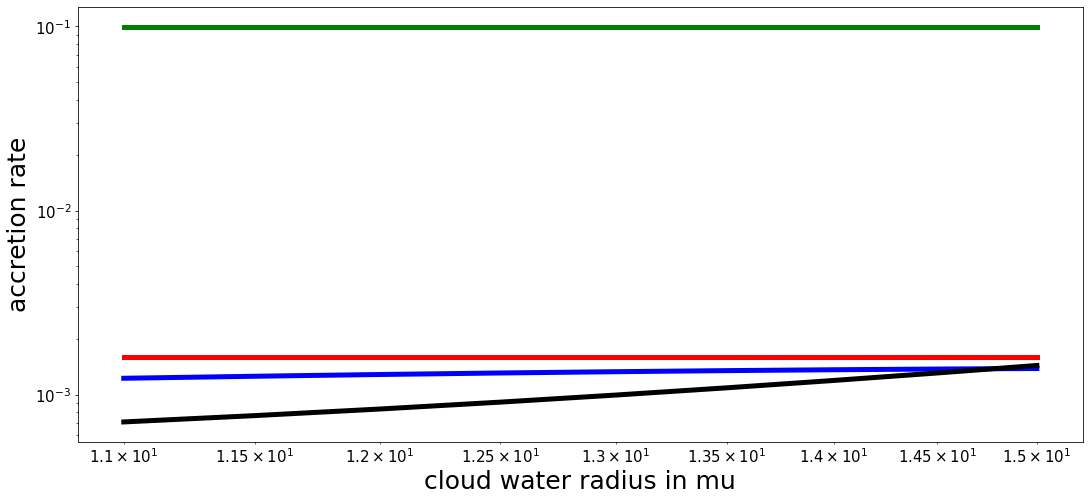

In [84]:

plt.plot(rc3d[iqr,iqc,:,irr,inu]*1e6, acc3d_model0[iqr,iqc,:,irr,inu], 'g-', linewidth=5)
plt.plot(rc3d[iqr,iqc,:,irr,inu]*1e6, acc3d_model2[iqr,iqc,:,irr,inu], 'b-', linewidth=5)
plt.plot(rc3d[iqr,iqc,:,irr,inu]*1e6, acc3d_model3[iqr,iqc,:,irr,inu], 'k-', linewidth=5)
plt.plot(rc3d[iqr,iqc,:,irr,inu]*1e6, accSB[iqr,iqc,:,irr,inu], 'r-', linewidth=5)

plt.xlabel('cloud water radius in mu')
plt.ylabel('accretion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()

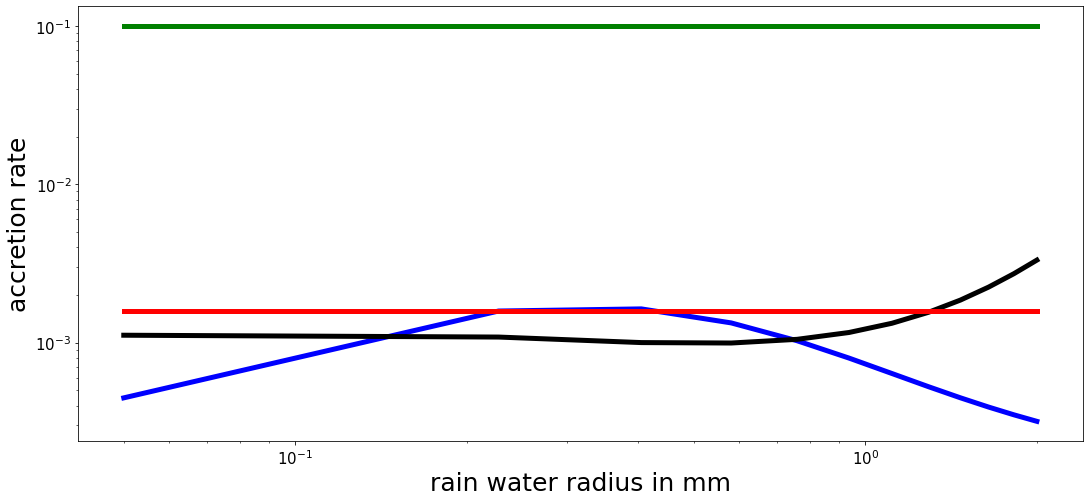

In [85]:

plt.plot(rr3d[iqr,iqc,irc,:,inu]*1e3, acc3d_model0[iqr,iqc,irc,:,inu], 'g-', linewidth=5)
plt.plot(rr3d[iqr,iqc,irc,:,inu]*1e3, acc3d_model2[iqr,iqc,irc,:,inu], 'b-', linewidth=5)
plt.plot(rr3d[iqr,iqc,irc,:,inu]*1e3, acc3d_model3[iqr,iqc,irc,:,inu], 'k-', linewidth=5)
plt.plot(rr3d[iqr,iqc,irc,:,inu]*1e3, accSB[iqr,iqc,irc,:,inu], 'r-', linewidth=5)

plt.xlabel('rain water radius in mm')
plt.ylabel('accretion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()